In [ ]:
import collections

import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay, Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
import matplotlib.cm as cm
import time
%matplotlib inline

# <center> First Point Query Location Attempt (Naive Method) </center>

In [ ]:
def Area2(a: np.array, b: np.array, c: np.array): #Scipy has  a determinant method, but it uses LU factorization (which is O(n^3))
  '''
    Left Test - Calculate determinant, if > 0, then point c lies 'to the left' of the segment.
  '''
  # tests whether point c lies to the right or left of the other two points
  area = ((b[0] - a[0]) * (c[1] - a[1])) - ((c[0] - a[0]) * (b[1] - a[1]))
  #area = (b[0][0] - a[0][0]) * (c[0][1] - a[0][1]) - (c[0][0] - a[0][0]) * (b[0][1] - a[0][1])
  return area #if area is less than 0, then left test fails

def query_region(vertices: np.array, corrected_regions: list, test_point: np.array):
  '''
  - Using the property that L2 voronoi regions are convex to do left tests on each polygon (The query can be improved to O(\log n), Exercise 7.4.3 Orourke)). 
  
  - Algorithm queries a voronoi diagram in O(k*n), where n is the number of edges and k is a constant query size so it is dependent on the input. 
  
  - I think the algorithm uses O(n) space and preprocessing time. 
  Basically I do left tests on the sum of vertices in the total number of regions. This is built with only arrays and lists.

  '''
  records = []
  for region in corrected_regions:
    local_records = []
    for i in range(1, len(region)): # regions are going in counter clockwise direction
        a = vertices[region[i-1]]
        b = vertices[region[i]]
        area = Area2(a, b, test_point)
        ###print(area)
        local_records.append(area)
    last_edge = Area2(vertices[region[-1]], vertices[region[0]], test_point)
    ###print("last edge", last_edge)
    local_records.append(last_edge)
    records.append(local_records)

  # return corrected_region index instead
  answer = [index for index, row in enumerate(records) if all(col > 0 for col in row)]
  ### print("point has been found in this region:", corrected_regions[answer[0]])
  return answer

def get_edges(vertices: np.array, corrected_regions: list):
  '''
  Adaptation from query_regions, returns the endpoints of each segment in each region in a nested list. Endpoints are stored as indexes of vertices as opposed to point coordinates.
  '''
  master_edge_list = []
  for region in corrected_regions:
    edge_list = []
    for i in range(1, len(region)): # 4/26/20 - pretty sure regions are going in counter clockwise direction, should probably double check though
        a = region[i-1]
        b = region[i]
        #area = Area2(a, b, test_point)
        edge = (a,b)
        #print(area)
        edge_list.append(edge)
    last_edge = (region[-1], region[0])
    #print(last_edge)
    edge_list.append(last_edge)
    master_edge_list.append(edge_list)
  return master_edge_list

# <center> DAG Construction </center>

In [ ]:
def make_adj_matrix(adj_list, n):
  adj_matrix = np.zeros((n,n))
  for polygon in adj_list:
    for edge in polygon:
        adj_matrix[edge[0], edge[1]] = 1
        adj_matrix[edge[1], edge[0]] = 1
        adj_matrix[edge[1], edge[1]] = -1
  return adj_matrix

def get_adj_edges(vertex, adj_matrix):
  '''
  Input:
  vertex = vertex index
  adj_matrix = np.ndarray

  Output:
  Returns an adjacent vertex edges list
  '''
  adj_edge_list = []
  for col in range(len(adj_matrix[vertex])):
    if adj_matrix[vertex][col] == 1:
      adj_edge_list.append(col)
      #print("adjacent!")
    if adj_matrix[vertex][col] == 0:
      #print(col, "is not adjacent", "to ", vertex)
      pass
  return adj_edge_list

def remove_sacred_points(index_counter, hull_points):
  '''
  Input: 
  index_counter and hull points (sacred points)

  Output: 
  index_counter_output is a list of the index vertices list minus the hull points
  '''
  index_counter_output = index_counter
  for vertex in index_counter:
    for sacred_vertex in hull_points: #sacred points are [2,0,4,1]
      if vertex == sacred_vertex:
        index_counter_output.remove(vertex)
        # print("remove scared point from index_counter_copy", index_counter_output)
  return index_counter_output

def make_independent_set(index_counter, hull_points, vertices, adj_matrix):
  '''
  Input: 
  Output: List of independent set vertices
  '''
  independent_set = []
  index_counter_copy = index_counter
  for vertex in index_counter_copy:
    for sacred_vertex in hull_points: #sacred points are [2,0,4,1]
      if vertex == sacred_vertex:
        index_counter_copy.remove(vertex)
        pass
      else:
        #find all neighbor vertices of vertex and remove their indexes from index_counter
        adj_edge_list = get_adj_edges(vertex, adj_matrix)
      for v in index_counter_copy:
          for adj_vertex in adj_edge_list:
            if v == adj_vertex:
              # print("vertex's are equal. Remove", adj_vertex, "from index_counter")
              index_counter_copy.remove(adj_vertex)
              independent_set.append(v)
              break

  return independent_set

def triangulate_vertices(vertices, plot=False):
  '''
  Triangulate a list of vertices and returns a list of triangles sorted lexicographically in the first slot
  '''
  tri = Delaunay(vertices)
  if plot==True:
    plt.triplot(vertices[:,0], vertices[:,1], tri.simplices.copy())
    plt.plot(vertices[:,0], vertices[:,1], 'o')
    plt.show()

  triangles_list = tri.simplices
  triangles_list = triangles_list[triangles_list[:,0].argsort()]
  return triangles_list

def make_triangle_hierarchy(independent_set):
  tri_level_list = []
  for n in range(1,200):
    if independent_set:
        independent_set_new = make_independent_set(independent_set, hull_points_index, vertices, adj_matrix)
        independent_set = independent_set_new
        # get in coordinates
        vertex_list_tri = [vertices[index] for index in independent_set]
        hull_points = [hull.points[index] for index in hull_points_index]

        # triangulate points (with hull points) and append list to binary tree level.
        full_points = vertex_list_tri + hull_points
        tri_level_list.append(triangulate_vertices(full_points))
    else:
      return tri_level_list
      break

# <center> DAG Class </center>

In [ ]:
class DirectedAcyclicGraph:
  def __init__(self, triangle_level_list, convex_hull, vertices, regions):
    self.root = convex_hull #region of index's that make the convex hull
    self.triangle_level_list = triangle_level_list
    self.size = len(self.triangle_level_list)
    self.DAGTree = [[Node("root", self.root,)]]
    self.vertices = vertices
    self.regions = regions

  def buildDAG(self):
    i = self.size-1
    level = 0

    while i > -1: # does something special then stops when i=0
      triangle_level = self.triangle_level_list[i]
      # print("triangle level when starting while loop is ", triangle_level)
      new_dag_level = []
      for triangle in triangle_level:
        node = Node("child", triangle)
        # make pointers towards root node
        self.nodePath(node, level) #assigns parent and children relationship for each child node created
        #append nodes to level
        new_dag_level.append(node)
      self.DAGTree.append(new_dag_level)
      new_dag_level = []
      i+= -1
      level+=1
    self.get_voronoi_regions()

  def nodePath(self, child, level):
    '''
    Checks if vertices are in any regions in the level above when constructing DAG
    '''
    parent_level = self.DAGTree[level]
    for parent_index in range(len(parent_level)):
      if any(i in child.triangle for i in parent_level[parent_index].triangle):
        child.parent.append(parent_level[parent_index])
        parent_level[parent_index].child.append(child)

  def get_voronoi_regions(self):
    for leaf in self.DAGTree[-1]:
      #print("current leaf triangle is", leaf.triangle)
      for index, region in enumerate(self.regions):
        #print("region value is", region)
        if any(i in leaf.triangle for i in region):
          #print("checking if leaf triangle", leaf.triangle, "is in", region)
          leaf.region = region #or corrected_region[index]

  def find_node(self, vertices: np.array, children_list: list, test_point: np.array):
    '''
    - Finds the child node that the point lies in. 
    - Returns node
    '''
    records = []
    for node in children_list:
      triangle = node.triangle
      local_records = []
      for i in range(1, len(triangle)):
          a = vertices[triangle[i-1]]
          b = vertices[triangle[i]]
          area = Area2(a, b, test_point)
          ###print(triangle, "area", area)
          local_records.append(area)
      last_edge = Area2(vertices[triangle[-1]], vertices[triangle[0]], test_point)
      ###print("last edge area", last_edge)
      local_records.append(last_edge)
      records.append(local_records)
    #print("records", records)
    answer = [index for index, row in enumerate(records) if all(col < 0 for col in row)] #triangle vertices are clockwise, so reversed the inequality sign
    if answer:
      #print("point is in this triangle", triangle)
      return node
    else:
      return None
      #return print(test_point, " is not in this triangle, terminate")

  def point_location(self, query_point):
    node_path = []
    i=0
    current_node_child_list = self.DAGTree[0][0].child
    node_path.append(current_node_child_list)
    #print("current_node_child_list is", current_node_child_list)
    while i < self.size:
      next_node = self.find_node(vertices, current_node_child_list, query_point)
      if next_node:
        current_node_child_list = next_node.child
        node_path.append(next_node)
        if not current_node_child_list:
          node_path.append(next_node.region)
          # print("reached the end, point lies in this region: ", next_node.region)
          return node_path
          # print("next_node.region value instead of next child", next_node.region)
          print("the leaf triangle is", next_node.triangle)
      else:
        # print('end in point_location at', self.DAGTree[0][0].triangle)
        return
      i += 1



class Node:
    def __init__(self, name, triangle, parent=None):
        self.name = name
        self.triangle = triangle #triangulation vertex list
        self.parent = []
        self.child = []
        self.region = None # corresponding voronoi region, only for leaf nodes

![picture!](https://drive.google.com/uc?id=1o9iFQeEQDATrUYxfZxS3DapDPE0tMVRY)


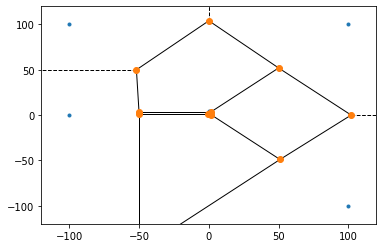

In [ ]:
# Make dumby points so I can understand the voronoi data structure better:
points = np.array([[0, 0], [0, 4], [0,3], [1, 2],
                    [2, 2], [100,100], [-100,0], [100,-100], [-100,100]]) # 
vor = Voronoi(points)
voronoi_plot_2d(vor)
plt.show()

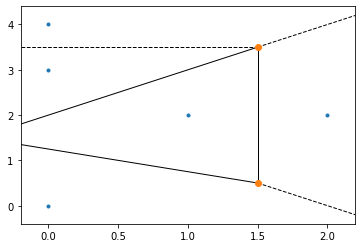

In [ ]:
points_no_extreme = np.array([[0, 0], [0, 4], [0,3], [1, 2],
                    [2, 2]])
vor_no_extreme = Voronoi(points_no_extreme)
voronoi_plot_2d(vor_no_extreme)
plt.show()

In [ ]:
vertices = vor.vertices # vertices are stored in ndarray, region is stored in a list
regions = vor.regions
corrected_regions = [i for i in regions if i and (-1 not in i)]
corrected_regions #corresponding index's of the vertices for each voronoi region

[[9, 10, 7, 8],
 [7, 6, 10],
 [8, 0, 5, 6, 7],
 [9, 2, 1, 3, 10],
 [10, 3, 4, 5, 6]]

In [ ]:
# Build adjacency matrix
adj_list = get_edges(vertices, corrected_regions)
n = vertices.shape[0]
adj_matrix = make_adj_matrix(adj_list, n) # makes adjacent_matrix

# Get index of points on convex hull
index_counter = [i for i in range(len(vertices))]
hull = ConvexHull(vertices)
hull_points_index = hull.vertices

# Remove "sacred CH points"
index_counter_no_ch = remove_sacred_points(index_counter, hull_points_index)
tri_level_list = make_triangle_hierarchy(index_counter_no_ch)

In [ ]:
index_counter_no_ch

[6, 9]

In [ ]:
myDag = DirectedAcyclicGraph(tri_level_list, hull_points_index, vertices, corrected_regions)

In [ ]:
myDag.buildDAG()

In [ ]:
myDag.DAGTree[3][4].triangle

array([2, 3, 5], dtype=int32)

# <center> **Query Speed Performance Test** </center>

In [ ]:
# Query time test for DAG
def time_query_DAG(count):
  queries = []
  start = time.time()
  for i in range(0,count):
    query_point = np.random.uniform(size=2) * np.random.randint(low=-100, high=100, size=2)
    #query_point = np.random.uniform(size=2) * np.random.randint(low=-1000, high=1000, size=2)
    # print("query point", query_point)
    query = myDag.point_location(query_point)
    queries.append(query)
  total_time = time.time() - start
  # print("elapsed time", total_time)
  # queries_drop_null = [x for x in queries if x != []]
  #return total_time
  return len(queries), total_time

def time_query(count):
  queries = []
  start = time.time()
  for i in range(0,count):
    query_point = np.random.uniform(size=2) * np.random.randint(low=-100, high=100, size=2)
    #query_point = np.random.uniform(size=2) * np.random.randint(low=-1000, high=1000, size=2)
    query = query_region(vertices, corrected_regions, query_point)
    queries.append(query)
  total_time = time.time() - start
  # print("elapsed time", total_time)
  # queries_drop_null = [x for x in queries if x != []]
  return len(queries), total_time

In [ ]:
x_10000, y_10000 = time_query_DAG(10000)
x_20000, y_20000 = time_query_DAG(20000)
x_30000, y_30000 = time_query_DAG(30000)
x_40000, y_40000 = time_query_DAG(40000)
x_50000, y_50000 = time_query_DAG(50000)
x_60000, y_60000 = time_query_DAG(60000)
x_70000, y_70000 = time_query_DAG(70000)

x1_10000, y1_10000 = time_query(10000)
x1_20000, y1_20000 = time_query(20000)
x1_30000, y1_30000 = time_query(30000)
x1_40000, y1_40000 = time_query(40000)
x1_50000, y1_50000 = time_query(50000)
x1_60000, y1_60000 = time_query(60000)
x1_70000, y1_70000 = time_query(70000)

In [ ]:
y0_dag = [y_10000, y_20000, y_30000, y_40000 , y_50000, y_60000, y_70000]
x0_dag = [x_10000, x_20000, x_30000, x_40000 , x_50000, x_60000, x_70000]

y0 = [y1_10000, y1_20000, y1_30000, y1_40000 , y1_50000, y1_60000, y1_70000]
x0 = [x1_10000, x1_20000, x1_30000, x1_40000 , x1_50000, x1_60000, x1_70000]

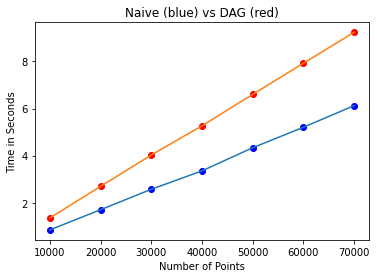

In [ ]:
plt.plot(x0,y0, 'bo');
plt.plot(x0,y0);
plt.plot(x0_dag,y0_dag, 'ro');
plt.plot(x0_dag,y0_dag);
plt.xlabel("Number of Points")
plt.ylabel("Time in Seconds")
plt.title("Naive (blue) vs DAG (red)")
plt.show()